In [1]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import ElectraForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#import gluonnlp as nlp
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
device = torch.device("cuda:0")

In [3]:
from transformers import AutoTokenizer
MODEL_NAME= "monologg/koelectra-base-v3-hate-speech"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='monologg/koelectra-base-v3-hate-speech', vocab_size=35000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

# Load Koco Dataset

In [5]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_hate_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_hate_test.txt", sep="\t")
koco_train_df.head(5)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


In [6]:
tokenized_train_sentences = tokenizer(
                            list(koco_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [8]:
train_label = koco_train_df["hate"].values
test_label =  koco_test_df["hate"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

In [9]:
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [10]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [11]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
from transformers import Trainer
#model_path = 'C:/Users/USER/Desktop/2022/KcELECTRA_output/KcELECTRA_hate_outputs/pytorch_model.bin'
#model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [13]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.727100
1000,0.741000
1500,0.732500
2000,0.716500
2500,0.604500
3000,0.595800
3500,0.639400
4000,0.611600
4500,0.471600
5000,0.449100


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_outputs\output\checkpoint-1000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-1000\con

Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_outputs\output\checkpoint-4500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_outputs\output\checkpoint-5000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_l

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-11000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-11000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-11500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-

Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_outputs\output\checkpoint-15000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-16500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/checkpoint-16500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoELECTRA_outputs\output\checkpoint-15500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipyker

TrainOutput(global_step=19740, training_loss=0.27567307607864294, metrics={'train_runtime': 1321.7994, 'train_samples_per_second': 59.737, 'train_steps_per_second': 14.934, 'total_flos': 2596929432975360.0, 'train_loss': 0.27567307607864294, 'epoch': 10.0})

In [14]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'eval_loss': 3.4625236988067627,
 'eval_accuracy': 0.6411889596602972,
 'eval_f1': 0.6343925134820768,
 'eval_precision': 0.6741671806879074,
 'eval_recall': 0.6364542674993495,
 'eval_runtime': 0.4099,
 'eval_samples_per_second': 1148.949,
 'eval_steps_per_second': 36.591,
 'epoch': 10.0}

In [15]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/pytorch_model.bin


In [16]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


              precision    recall  f1-score   support

           0       0.63      0.89      0.74       160
           1       0.58      0.52      0.55       189
           2       0.81      0.49      0.61       122

    accuracy                           0.64       471
   macro avg       0.67      0.64      0.63       471
weighted avg       0.66      0.64      0.63       471



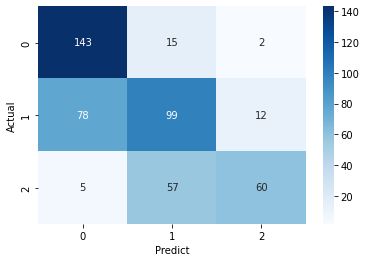

In [17]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predictions[0].argmax(-1)
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [18]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [19]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3737)
tensor(0.4034)


In [37]:
sig = torch.nn.Sigmoid()
pred = sig(torch.tensor(predictions[0]))
df = pd.DataFrame(pred.tolist())
df.to_csv("df.csv")